In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [35]:
import io

In [36]:
from google.colab import files
uploaded = files.upload()

Saving CELH.csv to CELH.csv


In [38]:
df = pd.read_csv(io.BytesIO(uploaded['CELH.csv']))
print(df)

           Date      Open      High       Low     Close  Adj Close   Average
0      1/4/2010  1.666667  1.683333  1.666667  1.666667   1.666667  1.670000
1      1/5/2010  1.666667  1.796667  1.500000  1.790000   1.790000  1.708667
2      1/6/2010  1.816667  1.816667  1.666667  1.783333   1.783333  1.773333
3      1/7/2010  1.683333  1.783333  1.683333  1.683333   1.683333  1.703333
4      1/8/2010  1.700000  1.776667  1.586667  1.773333   1.773333  1.722000
...         ...       ...       ...       ...       ...        ...       ...
2635  6/23/2020  3.426667  3.816667  3.386667  3.700000   3.700000  3.606000
2636  6/24/2020  3.603333  3.803333  3.430000  3.480000   3.480000  3.559333
2637  6/25/2020  3.483333  3.790000  3.433333  3.786667   3.786667  3.656000
2638  6/26/2020  3.803333  3.993333  3.570000  3.680000   3.680000  3.745333
2639  6/29/2020  3.680000  3.880000  3.503333  3.853333   3.853333  3.754000

[2640 rows x 7 columns]


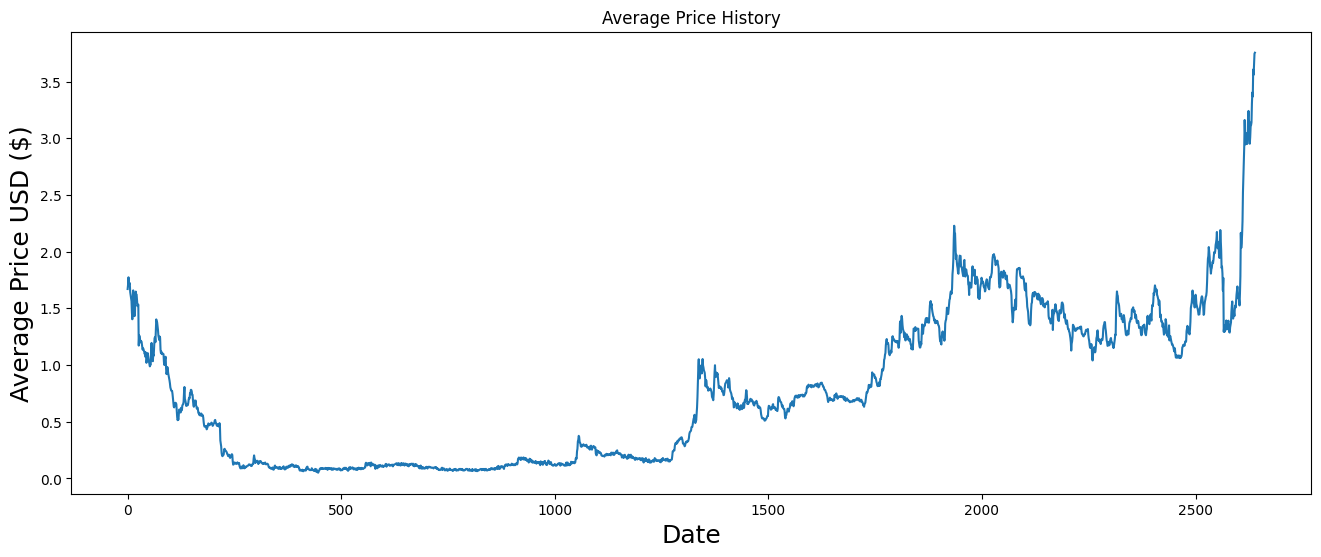

In [39]:
plt.figure(figsize=(16,6))
plt.title('Average Price History')
plt.plot(df['Average'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Average Price USD ($)', fontsize=18)
plt.show()

In [40]:
data = df.filter(['Average'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * 0.95 ))
window_size = 60
training_data_len

2508

In [41]:
sc = StandardScaler()
scaled_data = sc.fit_transform(dataset)
print('scaled_data.shape', len(dataset))
scaled_data

scaled_data.shape 2640


array([[1.3946222 ],
       [1.45384398],
       [1.55288737],
       ...,
       [4.43638017],
       [4.57320293],
       [4.5864767 ]])

In [42]:
train_data = scaled_data[0: int(training_data_len)]
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i <= window_size + 1:
      print('x_train', x_train)
      print('\n y_train', y_train)
      print()

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('x_train.shape', x_train.shape)

x_train [array([1.3946222 , 1.45384398, 1.55288737, 1.44567473, 1.47426511,
       1.47528608, 1.35377932, 1.31293644, 1.27209356, 1.23227195,
       1.07706968, 0.98619524, 1.2618833 , 1.37624239, 1.28230413,
       1.19551355, 1.02805909, 1.03929092, 1.30783131, 1.35990511,
       1.3200835 , 1.31804157, 1.2373777 , 1.16386088, 1.17509211,
       1.18428171, 0.63086396, 0.76666545, 0.75645519, 0.71254972,
       0.69008543, 0.67272781, 0.68906477, 0.66557983, 0.6237169 ,
       0.57674762, 0.59410525, 0.58491626, 0.56040973, 0.54509434,
       0.51548361, 0.54407368, 0.47566139, 0.53488347, 0.3980604 ,
       0.43277719, 0.4971041 , 0.52875676, 0.48791449, 0.45217736,
       0.41235605, 0.37968151, 0.35007016, 0.3766183 , 0.3735551 ,
       0.58593722, 0.6666014 , 0.53998891, 0.46749305, 0.41950281])]

 y_train [0.5113988285593102]

x_train [array([1.3946222 , 1.45384398, 1.55288737, 1.44567473, 1.47426511,
       1.47528608, 1.35377932, 1.31293644, 1.27209356, 1.23227195,
       1.0

In [43]:
print(x_train.shape[1])

60


In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
!pip install layers

In [45]:
import tensorflow as tf

In [46]:
def build_lstm_model():
  input = tf.keras.layers.Input(shape = (x_train.shape[1], 1), name = 'input')
  x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences = True))(input)
  x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences = False, dropout = 0.5))(x)
  output = tf.keras.layers.Dense(1, name = "last_dense")(x)
  model = tf.keras.Model(inputs = input, outputs = output)
  return model

LSTM_model = build_lstm_model()
LSTM_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 60, 256)           133120    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 last_dense (Dense)          (None, 1)                 129       
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 297601 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
epochs = 50
batch_size = 32
early_stopping_patience = 20

LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
price = LSTM_model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/50
77/77 [==============================] - 44s 439ms/step - loss: 0.0487
Epoch 2/50
77/77 [==============================] - 21s 270ms/step - loss: 0.0097
Epoch 3/50
77/77 [==============================] - 21s 276ms/step - loss: 0.0073
Epoch 4/50
77/77 [==============================] - 20s 258ms/step - loss: 0.0067
Epoch 5/50
77/77 [==============================] - 21s 279ms/step - loss: 0.0059
Epoch 6/50
77/77 [==============================] - 21s 275ms/step - loss: 0.0054
Epoch 7/50
77/77 [==============================] - 20s 256ms/step - loss: 0.0054
Epoch 8/50
77/77 [==============================] - 21s 274ms/step - loss: 0.0050
Epoch 9/50
77/77 [==============================] - 20s 260ms/step - loss: 0.0051
Epoch 10/50
77/77 [==============================] - 21s 277ms/step - loss: 0.0047
Epoch 11/50
77/77 [==============================] - 21s 277ms/step - loss: 0.0052
Epoch 12/50
77/77 [==============================] - 20s 262ms/step - loss: 0.0049
Epoch 13/50
7

In [48]:
test_data = scaled_data[training_data_len - window_size: ]
print('len(test_data): ', len(test_data))

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
  x_test.append(test_data[i - window_size:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = LSTM_model.predict(x_test)
predictions = sc.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

len(test_data):  192
5/5 [==============================] - 2s 59ms/step


0.27091630827574015

<ipython-input-49-8f188311654f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


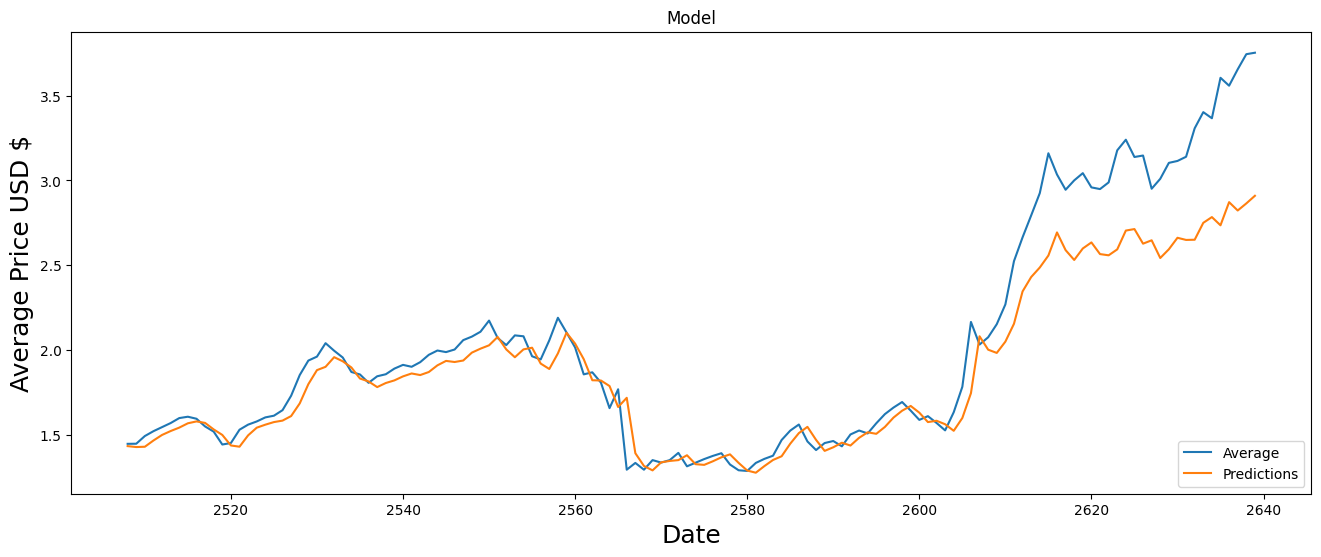

In [49]:
train = data[: training_data_len]
test = data[training_data_len: ]
test['Predictions'] = predictions

plt.figure(figsize = (16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Average Price USD $', fontsize = 18)
plt.plot(test[['Average', 'Predictions']])
plt.legend(['Average', 'Predictions'], loc = 'lower right')
plt.show()

In [50]:
test[:]

,Average,Predictions
2508,1.446000,1.432534
2509,1.446667,1.427027
2510,1.492000,1.428843
2511,1.520666,1.465666
2512,1.544667,1.498443
...,...,...
2635,3.606000,2.735600
2636,3.559333,2.872182
2637,3.656000,2.822915
2638,3.745333,2.864648
